In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = "ignore")
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/부실기업예측 프로젝트/data/service123.csv", encoding="utf-8")
df1 = pd.read_csv("/content/drive/My Drive/부실기업예측 프로젝트/data/manufacture.csv", encoding="utf-8")
df["sector"] = 1
df1["sector"] = 2
df = df.append(df1)
df.drop("income", axis = 1, inplace = True)
df

,name,code,year,casset,cdebt,asset,rearnings,debt,sales,employee,capital,equity,netincome,stock_num,stock,roe,ebt,interest,facevalue,sector
0,(주)가비아,79940,Dec-09,18535801.0,6045583.0,45179076.0,13556590.0,14060314.0,35644995.0,130.0,6367842.0,31118762.0,4441702.0,12735684.0,2130.0,18.43,5786033.0,0.0,500.0,1
1,(주)가비아,79940,Dec-10,23312665.0,8704012.0,52912228.0,18505855.0,15686573.0,40623302.0,155.0,6367842.0,37225655.0,5572559.0,12735684.0,3050.0,19.64,6783187.0,0.0,500.0,1
2,(주)가비아,79940,Dec-11,28837190.0,13905604.0,64954440.0,22695449.0,16288697.0,52838864.0,191.0,6367842.0,48665742.0,7014899.0,12735684.0,3950.0,18.06,8869912.0,0.0,500.0,1
3,(주)가비아,79940,Dec-12,31997486.0,14858349.0,85244515.0,28990858.0,26299269.0,69058144.0,211.0,6667842.0,58945247.0,9419144.0,13335684.0,4035.0,21.30,11450531.0,-492484.0,500.0,1
4,(주)가비아,79940,Dec-13,37411881.0,14999568.0,91231294.0,34684170.0,22631067.0,70675565.0,228.0,6667842.0,68600227.0,9505713.0,13335684.0,4790.0,15.65,11314450.0,-445102.0,500.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,현우산업(주),92300,Dec-10,NaN,NaN,NaN,NaN,NaN,NaN,287.0,NaN,NaN,NaN,NaN,4115.0,NaN,NaN,NaN,NaN,2
3594,현우산업(주),92300,Dec-09,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,7880.0,NaN,NaN,NaN,NaN,2
3595,현주컴퓨터(주),38960,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3596,후야인포넷(주),32050,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [4]:
len(df.code.unique())

763

# 새 섹션

In [5]:
len(df["code"].unique())

763

In [6]:
df.isna().sum()

name            0
code            0
year            0
casset       2064
cdebt        2064
asset        2064
rearnings    2064
debt         2064
sales        2064
employee     1037
capital      2064
equity       2064
netincome    2064
stock_num    2064
stock        1160
roe          2092
ebt          2064
interest     2064
facevalue    2064
sector          0
dtype: int64

# 1. 전처리 1) 중복 데이터 제거 2) 결측치 제거 3) 이상치 제거 
(3) box-plot으로 시각화 (2010도 부터 시작하도록 수정))
# 2. 년도 통일 ( 계산할수 있도록 숫자화 시키기)
# 3. 변수들 계산 (변수 계산식 폴더에 계산식 따라서 만들기)


In [7]:
# 자산이 0이거나 결측치일 경우 탈락
df_new= df.dropna(subset = ['asset'], how = 'any', axis=0)
idx = df_new[df_new.asset <= 0 ].index
df_new.drop(index= idx,inplace = True)
df_new.reset_index(inplace = True, drop=True)

In [8]:
df_new.isna().sum()

name           0
code           0
year           0
casset         0
cdebt          0
asset          0
rearnings      0
debt           0
sales          0
employee     214
capital        0
equity         0
netincome      0
stock_num      0
stock        255
roe           28
ebt            0
interest       0
facevalue      0
sector         0
dtype: int64

In [9]:
#[중복 회사 전처리]
df_new = df_new.drop_duplicates(['code','year'])
df_new # 총 9개의 완전 중복의 회사가 탈락 됨

,name,code,year,casset,cdebt,asset,rearnings,debt,sales,employee,capital,equity,netincome,stock_num,stock,roe,ebt,interest,facevalue,sector
0,(주)가비아,79940,Dec-09,18535801.0,6045583.0,45179076.0,13556590.0,14060314.0,35644995.0,130.0,6367842.0,31118762.0,4441702.0,12735684.0,2130.0,18.43,5786033.0,0.0,500.0,1
1,(주)가비아,79940,Dec-10,23312665.0,8704012.0,52912228.0,18505855.0,15686573.0,40623302.0,155.0,6367842.0,37225655.0,5572559.0,12735684.0,3050.0,19.64,6783187.0,0.0,500.0,1
2,(주)가비아,79940,Dec-11,28837190.0,13905604.0,64954440.0,22695449.0,16288697.0,52838864.0,191.0,6367842.0,48665742.0,7014899.0,12735684.0,3950.0,18.06,8869912.0,0.0,500.0,1
3,(주)가비아,79940,Dec-12,31997486.0,14858349.0,85244515.0,28990858.0,26299269.0,69058144.0,211.0,6667842.0,58945247.0,9419144.0,13335684.0,4035.0,21.30,11450531.0,-492484.0,500.0,1
4,(주)가비아,79940,Dec-13,37411881.0,14999568.0,91231294.0,34684170.0,22631067.0,70675565.0,228.0,6667842.0,68600227.0,9505713.0,13335684.0,4790.0,15.65,11314450.0,-445102.0,500.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,현대에이치티(주),39010,Dec-11,34230398.0,25312450.0,51684522.0,14706819.0,27924621.0,50084077.0,114.0,4312500.0,23759901.0,-6698264.0,8625000.0,4820.0,-25.01,-6346904.0,-33560.0,500.0,2
3837,현대에이치티(주),39010,Dec-10,36268950.0,22701929.0,54274937.0,21571287.0,24437516.0,61672631.0,158.0,4312500.0,29837421.0,-3851841.0,8625000.0,2410.0,-12.92,-3353139.0,-9683.0,500.0,2
3838,현우산업(주),92300,Dec-20,77679888.0,53419540.0,174061735.0,39618385.0,98835541.0,152927637.0,381.0,7702969.0,75226194.0,1121137.0,15405937.0,3565.0,1.49,2125421.0,-1142809.0,500.0,2
3839,현우산업(주),92300,Dec-19,56036039.0,65797604.0,165964411.0,39989977.0,90483720.0,168476354.0,451.0,7651264.0,75480692.0,2239111.0,15302527.0,3415.0,3.05,3249626.0,-1230855.0,500.0,2


In [10]:
# 결산 월인 12월이 아닌경우 전처리.
n = 0
for idx, i in enumerate(df_new.year):
  month = i[0:3]
  if month != 'Dec':
    print(df_new[df_new.index == idx])
    n += 1
    df_new.drop(index= idx,inplace = True)
print(n)

         name   code    year  ...   interest  facevalue  sector
360  (주)스포츠서울  39670  Dec-12  ... -1750214.0      500.0       1

[1 rows x 20 columns]
         name   code    year  ...  interest  facevalue  sector
361  (주)스포츠서울  39670  Dec-13  ... -902990.0      500.0       1

[1 rows x 20 columns]
         name   code    year  ...  interest  facevalue  sector
362  (주)스포츠서울  39670  Mar-15  ... -279011.0      500.0       1

[1 rows x 20 columns]
         name   code    year  ...  interest  facevalue  sector
363  (주)스포츠서울  39670  Mar-16  ... -205658.0      500.0       1

[1 rows x 20 columns]
         name   code    year      casset  ...       ebt  interest  facevalue  sector
364  (주)스포츠서울  39670  Mar-17  12475008.0  ... -507279.0 -264066.0      500.0       1

[1 rows x 20 columns]
         name   code    year  ...   interest  facevalue  sector
365  (주)스포츠서울  39670  Mar-18  ... -1204641.0      500.0       1

[1 rows x 20 columns]
        name   code    year     casset  ...        ebt  in

In [11]:
# 1년 이하 기업들 탈락
n = 0
for i in df_new.code.unique():
    data = df_new[df_new.code == i]
    if len(data)<=1:
        print(data)
        n += 1
        df_new.drop(df_new[df_new.code == i].index, inplace =True)
print(n)
        

        name   code    year  ...  interest  facevalue  sector
34  (주)골드카운티  58900  Dec-09  ...       0.0      500.0       1

[1 rows x 20 columns]
             name    code    year  ...  interest  facevalue  sector
68  (주)네이블커뮤니케이션즈  153460  Dec-14  ...    -366.0      500.0       1

[1 rows x 20 columns]
       name    code    year  ...  interest  facevalue  sector
204  (주)리파인  377450  Dec-20  ...       0.0     5000.0       1

[1 rows x 20 columns]
          name    code    year  ...  interest  facevalue  sector
261  (주)바이브컴퍼니  301300  Dec-20  ... -332883.0      500.0       1

[1 rows x 20 columns]
               name    code    year  ...  interest  facevalue  sector
284  (주)비즈니스온커뮤니케이션  138580  Dec-20  ...    -107.0      500.0       1

[1 rows x 20 columns]
        name    code    year  ...  interest  facevalue  sector
285  (주)비트나인  357880  Dec-20  ...  -99206.0      500.0       1

[1 rows x 20 columns]
          name   code    year  ...  interest  facevalue  sector
356  (주)수산아이앤티  50

In [12]:
# 주가 데이터 존재하지 않을 시 탈락, 주가 데이터가 없는 경우는 당해 년도에 아직 상장이 되지 않은 경우이기 때문
df_new = df_new.dropna(subset = ['stock'], how = 'any', axis = 0)

In [13]:
df_new.to_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/df_employee.csv")

## 결측치 처리

In [14]:
### ROE의 경우 당기순이익 / 자본총액 으로 계산
df_new.roe = df_new.roe.fillna(df_new.netincome / df_new.equity)

# 주요 필요 변수들 계산

In [15]:
#pbr 값 계산
df_new["pbr"] = df_new["stock"] / (df_new.equity*1000/df_new.stock_num) 
# ebit 값 계산
df_new['ebit'] = df_new.ebt - df_new.interest
# 자본 잠식률 계산
df_new["erosion"] = (df_new["capital"]-df_new["equity"])/df_new["capital"]

In [16]:
df_new.isna().sum()

name         0
code         0
year         0
casset       0
cdebt        0
asset        0
rearnings    0
debt         0
sales        0
employee     4
capital      0
equity       0
netincome    0
stock_num    0
stock        0
roe          0
ebt          0
interest     0
facevalue    0
sector       0
pbr          0
ebit         0
erosion      0
dtype: int64

In [17]:
df_new["code"].value_counts()

65680     12
59090     12
42420     12
25440     12
95660     12
          ..
337930     1
219130     1
87600      1
198080     1
318020     1
Name: code, Length: 462, dtype: int64

In [18]:
df_new[df_new.employee.isna()].name.unique()

array(['(주)루멘스', '(주)씨유전자', '(주)한프', '잘만테크(주)'], dtype=object)

In [19]:
df_new.to_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/df_new.csv")

In [20]:
len(df_new.code.unique())

462

# 상폐기업 리스트 추출

In [21]:
df3 = pd.read_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/not_bankr1.csv")
df4 = pd.read_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/not_bank2.csv")
df3 = df3.append(df4)

In [22]:
df3

,name,code,year,casset,cdebt,asset,rearnings,debt,sales,employee,capital,equity,netincome,stock,income,roe
0,(주)가비아,79940,10-Dec,27.61,6783187.0,446894.0,NaN,0.0,0.0,5572559.0,1210628.0,670314.0,579609.0,0.0,NaN,NaN
1,(주)가비아,79940,11-Dec,22.99,8869912.0,367186.0,NaN,0.0,0.0,7014899.0,1855013.0,1089676.0,400646.0,0.0,NaN,NaN
2,(주)가비아,79940,12-Dec,20.11,11450531.0,493791.0,NaN,0.0,0.0,9419144.0,2031388.0,4393774.0,548447.0,0.0,NaN,NaN
3,(주)가비아,79940,13-Dec,24.57,11314450.0,444815.0,0.0,0.0,0.0,9505713.0,1808737.0,3316110.0,858548.0,0.0,NaN,NaN
4,(주)가비아,79940,14-Dec,26.07,8012086.0,340937.0,0.0,0.0,0.0,6752737.0,1259349.0,998245.0,471746.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,현우산업(주),92300,Dec-16,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,NaN,NaN,3160.0,NaN,NaN
2829,현우산업(주),92300,Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,438.0,NaN,NaN,NaN,3330.0,NaN,NaN
2830,현우산업(주),92300,Dec-18,55942823.00,55056133.0,155155193.0,39145075.0,83818532.0,147756321.0,452.0,7158654.0,71336661.0,6181057.0,3185.0,4723525.0,8.66
2831,현우산업(주),92300,Dec-19,56036039.00,65797604.0,165964411.0,39989977.0,90483720.0,168476354.0,451.0,7651264.0,75480692.0,2239111.0,3415.0,5129417.0,3.05


In [23]:
#상폐기업 추출
name_list=df_new["name"].unique()
name_code = df_new[["name","code"]]
name_code.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
name = []
for a in name_list: 
  if a not in df3["name"].unique():
    name.append(a)
bankrupt = name_code[name_code["name"].isin(name)]
len(bankrupt)

60

# 변수 만들기

In [24]:
# 년도로 변환 식
df_new.year = df_new.year.map(lambda x : "20"+x[4:6])


In [25]:
df_new = df_new.sort_values(["code","year"])
df_new.reset_index(drop = True, inplace = True)
df_new['year_code'] = df_new['year'].astype(str).str.cat(df_new['code'].astype(str))
df_new = df_new.astype({'year': int})
df_new["last_year"] = (df_new["year"]-1)
df_last = df_new[["code","year","asset","sales","employee","roe","pbr","erosion"]]
df_last.rename(columns = {"year":"last_year","asset":"asset2","sales":"sales2","employee":"employee2","roe":"roe2","pbr":"pbr2","erosion":"erosion2"},inplace = True)
df_new["year2"] = (df_new["year"]-2)
df_merge = pd.merge(left = df_new , right = df_last, how = "left", on =["code","last_year"])
# 3년 데이터 비교를 위한 column생성
df_2last = df_new[["code","year","erosion"]]
df_2last.rename(columns = {"year":"year2","erosion":"erosion3"},inplace=True)

In [26]:
df_merge= df_merge.dropna(subset = ['pbr2'], how = 'any', axis=0)
# 일단 계산이 돌아갈 수 있도록 nan값 전부 탈락 시킴(employee 랑 원래 지워야 하는 원년 데이터 삭제))
df_merge.dropna(inplace = True)

In [27]:
def variables(df):
    df["x1"] = (df["casset"]-df["cdebt"]) / df["asset"]
    df["x2"] = df["rearnings"] / df["asset"]
    df["x3"] = df["ebit"]/df["asset"]
    df["x4"] = (df["stock"] * df["stock_num"]) / (df["debt"]*1000)
    df["x5"] = df["sales"] / df["asset"]
    df["om"] = df["ebit"] / df["sales"]
    df["ga"] = (df["asset"] - df["asset2"]) / df["asset2"]
    df["gs"] = (df["sales"] - df["sales2"]) / df["sales2"]
    df["ge"] = (df["employee"] - df["employee2"]) / df["employee2"]
    df["croe"] = df["roe"] - df["roe2"]
    df["cpb"] = df["pbr"] - df["pbr2"]

    return df

In [28]:
df_variable =variables(df_merge)
df_variable.isna().sum()

name         0
code         0
year         0
casset       0
cdebt        0
asset        0
rearnings    0
debt         0
sales        0
employee     0
capital      0
equity       0
netincome    0
stock_num    0
stock        0
roe          0
ebt          0
interest     0
facevalue    0
sector       0
pbr          0
ebit         0
erosion      0
year_code    0
last_year    0
year2        0
asset2       0
sales2       0
employee2    0
roe2         0
pbr2         0
erosion2     0
x1           0
x2           0
x3           0
x4           0
x5           0
om           0
ga           0
gs           0
ge           0
croe         0
cpb          0
dtype: int64

In [29]:
# 부도 상황에 대한 확인
df_white = pd.read_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/crawling.csv")
df_white.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [30]:
regex = "\(.*\)|\s-\s.*"
bankrupt.name = bankrupt.name.apply(lambda x: re.sub(regex,"", x))
df_black = df_white[df_white["회사명"].isin(bankrupt.name)]
df_black.reset_index(inplace = True, drop = True)
df_gray = pd.merge(left = df_black , right = bankrupt, how = "left", left_on=["회사명"], right_on=["name"])
df_gray["year"] = df_gray["공시발생일"].apply(lambda x : x[0:4])
df_gray = df_gray.astype({'year': int})
df_gray

,회사명,공시발생일,폐지사유,name,code,year
0,큐리어스,2012-11-27,"기업의 계속성, 경영의 투명성 또는 기타 코스닥시장의 건전성 등을 종합적으로 고려하...",큐리어스,45050,2012
1,넷웨이브,2012-11-17,기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지 기준에 해당한다고 결정,넷웨이브,47730,2012
2,엑큐리스,2012-11-16,피흡수합병,엑큐리스,48460,2012
3,인스프리트,2012-10-12,자본잠식률 50% 이상으로 관리종목 지정 이후 최근 반기의 재무제표에 대한 감사인의...,인스프리트,73130,2012
4,동양텔레콤,2012-09-11,2회 연속 자본잠식률 50%이상,동양텔레콤,7150,2012
5,허메스홀딩스,2012-06-12,감사의견 의견거절,허메스홀딩스,12400,2012
6,미리넷,2012-04-13,자본전액잠식,미리넷,56710,2012
7,미성포리테크,2012-04-13,자본전액잠식,미성포리테크,94700,2012
8,씨티엘테크,2012-02-08,기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지 기준에 해당한다고 결정,씨티엘테크,88960,2012
9,에이스앤파트너스,2012-01-18,피흡수합병,에이스앤파트너스,32930,2012


In [31]:
# 그후 if in 을 통해 파산 / 부도 관련 정보 확인 => bankrupt 판단
df_black["폐지사유"].value_counts()

자본전액잠식                                                                                                                                5
감사의견거절(감사범위 제한)                                                                                                                       5
피흡수합병                                                                                                                                 5
기업의 계속성, 경영의 투명성 또는 기타 코스닥시장의 건전성 등을 종합적으로 고려하여 상장폐지가 필요하다고 인정                                                                        4
감사의견 거절(감사범위 제한 및 계속기업 존속능력에 대한 불확실성)                                                                                                 3
기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당한다고 결정                                                                                      2
기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지 기준에 해당한다고 결정                                                                                     2
감사의견거절(감사범위 제한 및 계속기업으로서의 존속능력에 대한 불확실성)        

In [32]:
# 부도기준 1 KInd 폐지사유 적용
n = 0
idx_num = []
for i in df_gray.code.unique():
    option = df_gray[df_gray.code == i]["폐지사유"].values
    option = option.tolist()[0]
    if "부도" in option or "파산" in option or "잠식" in option or "감사" in option or "계속성" in option or "정지" in option or "미제출" in option or "연속" in option:
        data = df_variable[df_variable.code == i]
        if len(data) != 0:
            max_col = data[data.year == max(data.year)]
            n+=1
            idx_num.append(max_col.index.values[0])

In [33]:
n=0
for i in df_black["폐지사유"].values:
    if "부도" in i or "파산" in i or "잠식" in i or "감사" in i or "계속성" in i or "정지" in i or "미제출" in i or "연속" in i:
        n+=1
    else :
        n+=0
print(n)

44


In [34]:
df_variable["bankrupt1"] = df_variable.index.map(lambda x: 1 if x in idx_num else 0)
df_variable.bankrupt1.value_counts()

0    2910
1      43
Name: bankrupt1, dtype: int64

In [35]:
# 부도 기준 2 3년 연속 자본잠식 상태일 경우
df_variable = pd.merge(left = df_variable, right = df_2last, how = "left", on = ["code","year2"])
def f(x,y,z):
    if x >= 1:
        return 1
    if x >= 0 and y >= 0 and z >= 0:
        return 1
    # if x >= 0:
    #     return 1
    else : return 0
df_variable['bankrupt2'] = df_variable.apply(lambda x: f(x['erosion'], x['erosion2'],x['erosion3']), axis=1)
df_variable.bankrupt2.fillna(0)


0       0
1       0
2       0
3       0
4       0
       ..
2948    0
2949    0
2950    0
2951    0
2952    0
Name: bankrupt2, Length: 2953, dtype: int64

In [36]:
df_variable.bankrupt2.value_counts()

0    2907
1      46
Name: bankrupt2, dtype: int64

In [37]:
def combine(x,y):
    if x == 1 or y == 1:
        return 1
    else:
        return 0

df_variable["bankrupt"] = df_variable.apply(lambda x : combine(x["bankrupt1"],x["bankrupt2"]), axis = 1)

In [40]:
len(df_variable[df_variable["bankrupt"] == 1].code.unique())

60

In [ ]:
# 사용할 변수만 뽑기
df_select = df_variable[["name","code","year","sector","x1","x2","x3","x4","x5","om","ga","gs","ge","croe","cpb","bankrupt"]]
df_select.reset_index(inplace = True, drop = True)
df_select.to_csv("/content/drive/MyDrive/부실기업예측 프로젝트/data/variable.csv")

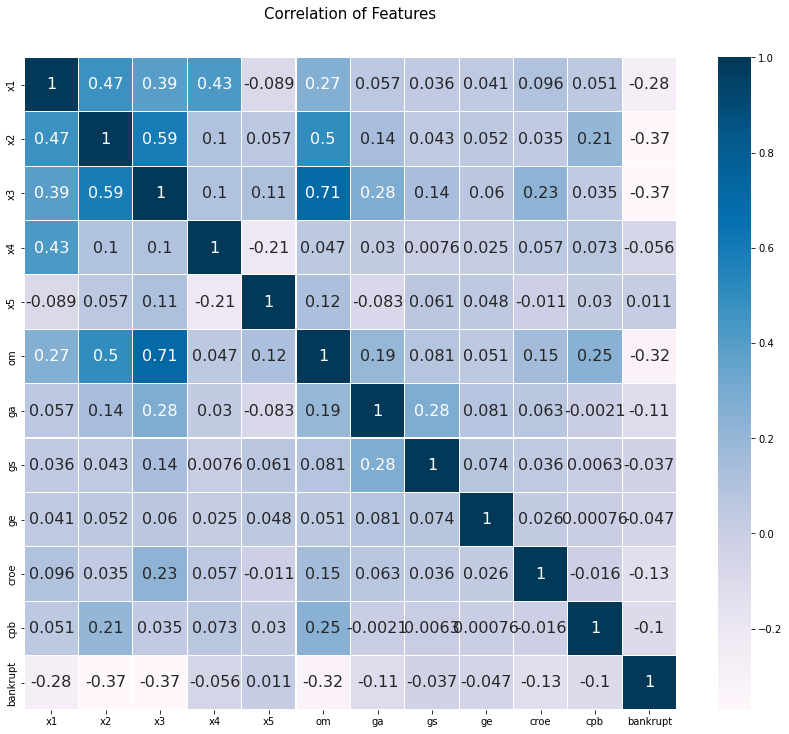

In [ ]:
heatmap_data = df_select[["x1","x2","x3","x4","x5","om","ga","gs","ge","croe","cpb","bankrupt"]]
import matplotlib.pyplot as plt 
import seaborn as sns

colormap = plt.cm.PuBu
plt.figure(figsize=(15, 12)) 
plt.title("Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [ ]:
# 이상치 탐색 및 처리

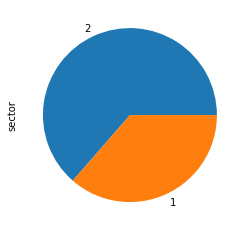

In [ ]:
% matplotlib inline

df_select["sector"].value_counts().plot(kind = "pie")

In [ ]:
x = df_select[['x1','x2','x3','x4','x5','om','ga','gs','ge','croe','cpb']]
x.describe()

,x1,x2,x3,x4,x5,om,ga,gs,ge,croe,cpb
count,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000
mean,0.208083,0.141445,-0.000855,4.674490,0.900806,-0.038971,0.082715,0.092122,0.036625,-1.891962,0.011413
std,0.272958,0.551379,0.190847,7.977560,0.542770,0.536773,0.312697,0.599627,0.618213,76.103817,5.984693
min,-2.088717,-10.075118,-4.736077,0.010324,0.026521,-10.216555,-0.795735,-0.989007,-0.993387,-2327.700000,-277.189925
25%,0.033619,-0.004990,-0.032855,0.958965,0.541256,-0.042314,-0.045458,-0.108515,-0.087209,-9.690000,-0.320528
50%,0.207251,0.216282,0.029594,2.090115,0.794136,0.032289,0.043993,0.033358,0.010152,-1.260000,-0.013246
75%,0.395436,0.442852,0.077694,5.312561,1.145227,0.093980,0.148541,0.177474,0.096541,5.440000,0.364165
max,0.907736,1.897654,1.344465,164.626433,4.912836,4.246224,5.257899,18.561333,18.277778,2344.710000,71.505808


In [ ]:
x.skew()

x1      -0.589772
x2      -5.255697
x3      -8.502735
x4       7.317923
x5       1.832247
om      -8.732935
ga       5.185614
gs      14.200742
ge      17.638192
croe     1.381400
cpb    -33.210696
dtype: float64

In [ ]:
x.kurtosis()
#큰 값의 이상치들이 많이 존재

x1         2.798527
x2        64.605125
x3       165.043243
x4        99.758590
x5         6.339952
om       137.704622
ga        58.072818
gs       353.734649
ge       412.889397
croe     623.989559
cpb     1582.433500
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45fd121fd0>,
      dtype=object)

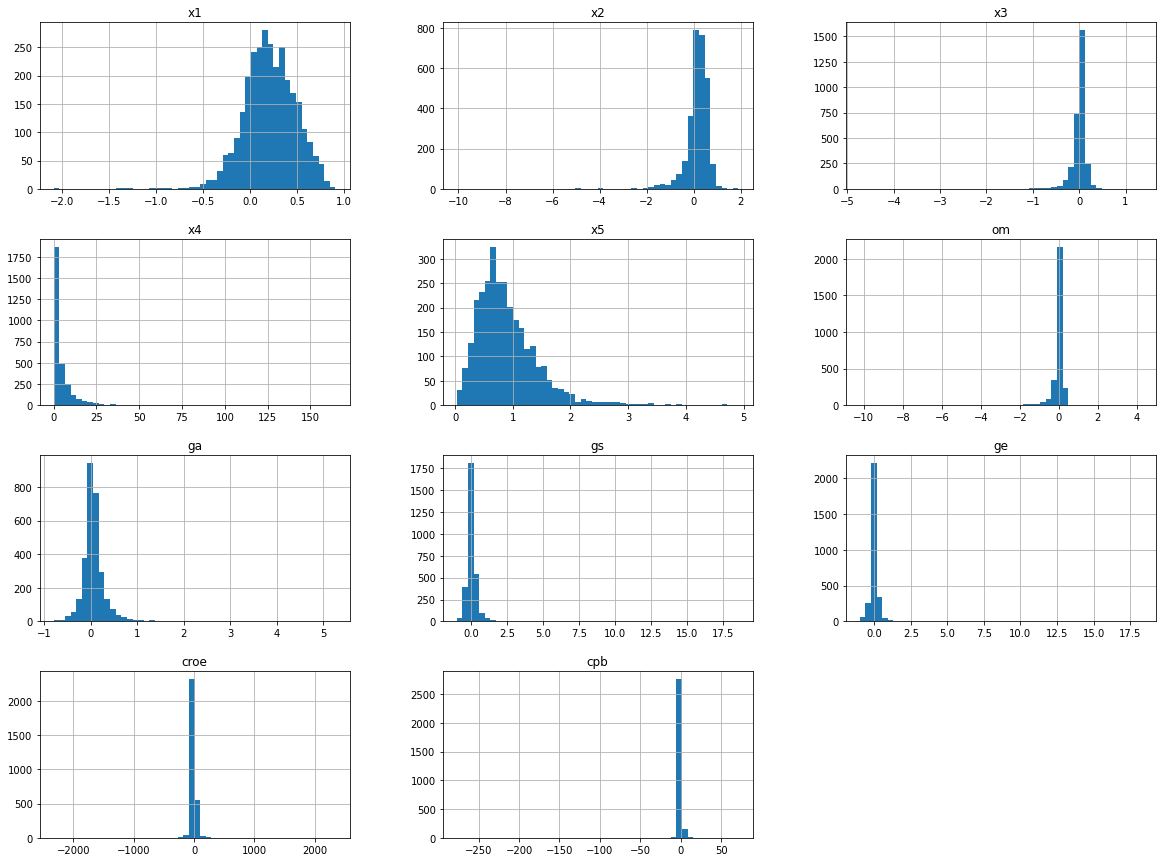

In [ ]:
import matplotlib.pyplot as plt
x.hist(bins = 50, figsize = (20,15))

In [ ]:
# 따라서 이상치들의 제거/치환가 필요, 
# 우선, 이상치 탐색 => 제거 / 치환 => 안될수도 아무튼 봐야함 (1.제거 2. 파산 개수(큰 변화 없다 = 제거) 3. 큰변화 있다.(숫자, 파산사라짐) 4. 치환)
df_select

,name,code,year,sector,x1,x2,x3,x4,x5,om,ga,gs,ge,croe,cpb,bankrupt
0,(주)대유플러스,300,2011,2,-0.027601,0.013323,0.020035,0.369703,0.553239,0.036214,0.330708,0.417533,0.095775,-10.56,0.669980,0
1,(주)대유플러스,300,2012,2,0.049332,-0.012951,-0.003058,0.255488,0.622598,-0.004911,0.006649,0.132851,0.154242,-11.56,-0.812564,0
2,(주)대유플러스,300,2013,2,0.094337,-0.006652,0.038567,0.218075,0.662727,0.058194,0.048990,0.116602,0.120267,19.23,-0.207904,0
3,(주)대유플러스,300,2014,2,0.047961,-0.019832,0.021306,0.180737,0.710024,0.030008,0.105457,0.184351,-0.683897,-11.49,-0.061619,0
4,(주)대유플러스,300,2015,2,0.041981,-0.028575,0.021317,0.154693,0.631994,0.033730,0.110126,-0.011874,0.094340,-0.83,-0.029684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,에스비아이핀테크솔루션즈(주),950110,2017,1,0.153422,0.127255,0.048081,0.947723,0.702515,0.068441,0.115890,0.242674,-0.024793,-1.64,-0.115420,0
2949,에스비아이핀테크솔루션즈(주),950110,2018,1,0.063765,0.086420,0.045783,0.883986,0.520584,0.087945,1.053954,0.522040,0.076271,15.86,4.930841,0
2950,에스비아이핀테크솔루션즈(주),950110,2019,1,0.068871,0.093612,0.045327,1.201257,0.257288,0.176173,0.222593,-0.395759,-0.039370,1.43,0.644057,0
2951,에스비아이핀테크솔루션즈(주),950110,2020,1,0.149909,0.134399,0.055893,0.755709,0.345795,0.161636,-0.106306,0.201125,-0.098361,-7.95,-4.721293,0


# 이상치

In [ ]:
# 박스플롯 이상치

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def outlier_iqr(data):
  q1,q3 = np.percentile(data, [25,75])
  iqr = q3 - q1
  lower_bound = q1 - (iqr * 1.5)
  upper_bound = q3 + (iqr * 1.5)

  return np.where((data > upper_bound)|(data < lower_bound))

x1


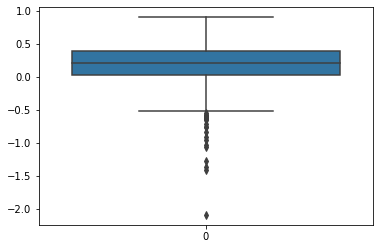

20
15
x2


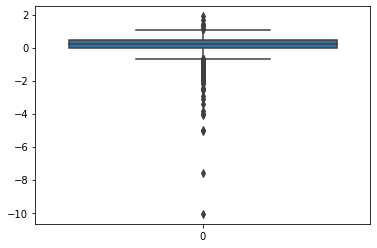

154
32
x3


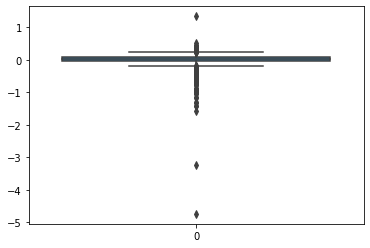

254
36
x4


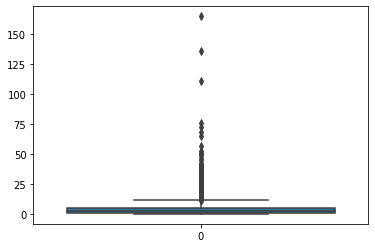

263
3
x5


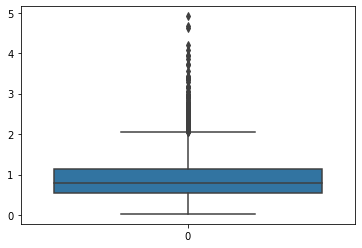

95
10
om


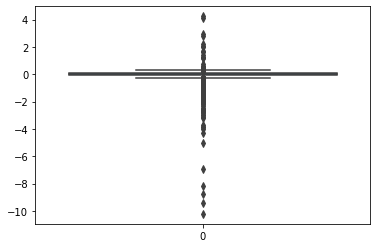

376
44
ga


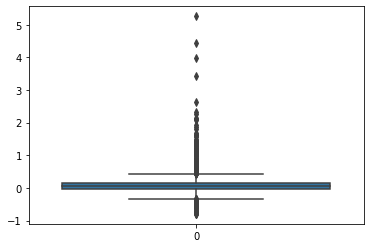

272
24
gs


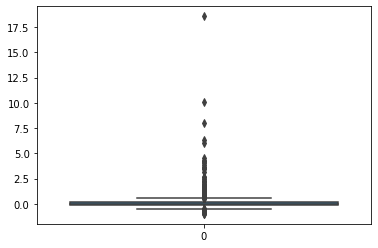

214
15
ge


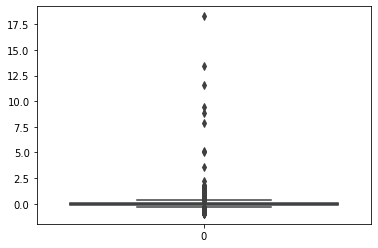

285
21
croe


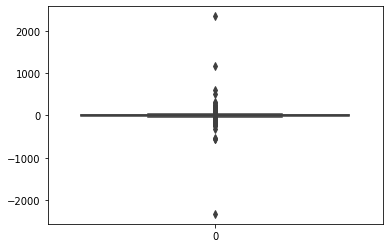

456
47
cpb


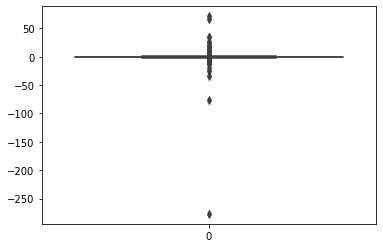

444
39


In [ ]:
y = ['x1','x2','x3','x4','x5','om','ga','gs','ge','croe','cpb']

for i in y :
  
  print(i)
  sns.boxplot(data=df_select[i])
  plt.show()

  i_outlier_id = outlier_iqr(df_select[i])[0]
  print(len(df_select.loc[i_outlier_id,'bankrupt']))
  print(sum(df_select.loc[i_outlier_id,'bankrupt']))
# 이상치 처리의 경우 이상치 내에 파산기업이 포함된 경우가 너무 많기 때문에 이상치 제거를 진행하지 않기로 결정